In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 4.5 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import tf
import matplotlib.animation as animation
from matplotlib.animation import (
    FuncAnimation,
)

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



# Constantes e Parâmetros da Rede

In [ ]:
SAMPLE_POINTS = 2000
T_START = 0
T_END = WIDTH = LENGTH = 1.0
ALPHA = 2
ARCHITECTURE = (
    [3] + [60] * 5 + [1]
)
ACTIVATION = "tanh"
INITIALIZER = "Glorot uniform"
LEARNING_RATE = 1e-3
LOSS_WEIGHTS = [
    10,
    1,
    1,
    1,
    1,
    10,
]  # Pesos dos componentes da função de perda
ITERATIONS = 10000  # Número de épocas
OPTIMIZER = "adam"  # Otimizador
BATCH_SIZE = 32

# Equação Diferencial

In [ ]:
def pde(X, T):
    # Calculate second derivatives (Hessians) of T with respect to X in both dimensions
    dT_xx = dde.grad.hessian(T, X, i=0, j=0)
    dT_yy = dde.grad.hessian(T, X, i=1, j=1)

    # Calculate first derivative (Jacobian) of T with respect to X in time dimension
    dT_t = dde.grad.jacobian(T, X, j=2)

    # Return the defined PDE
    return dT_t - ALPHA * (dT_xx + dT_yy)

# Condições de Contorno

In [ ]:
def boundary_right(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, WIDTH)


def boundary_left(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, 0)


def boundary_top(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, LENGTH)


def boundary_bottom(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, 0)

# Condição inicial

In [ ]:
# Define initial condition
def boundary_initial(X, on_initial):
    _, _, t = X
    return on_initial and np.isclose(t, 0)

# Inicializa com o campo de temperaturas sendo zero
def init_func(X):
    t = np.zeros((len(X), 1))
    return t

In [ ]:
def constraint_top(X):
    return np.ones((len(X), 1)) # No contorno do topo temperatura é sempre 100 K (normalizado)

def func_zero(X):
    return np.zeros(
        (len(X), 1)
    )

# Definindo geometrias

In [ ]:
# Define geometry and time domains
geom = dde.geometry.Rectangle([0, 0], [WIDTH, LENGTH])  # Geometria
timedomain = dde.geometry.TimeDomain(0, T_END)  # Tempo
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [ ]:
# Condição de contorno e condição inicial
bc_l = dde.DirichletBC(geomtime, func_zero, boundary_left)
bc_r = dde.DirichletBC(geomtime, func_zero, boundary_right)
bc_up = dde.DirichletBC(geomtime, constraint_top, boundary_top)
bc_low = dde.DirichletBC(geomtime, func_zero, boundary_bottom)
ic = dde.IC(geomtime, init_func, boundary_initial)

In [ ]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_l, bc_r, bc_up, bc_low, ic],
    num_domain=int(SAMPLE_POINTS),
    num_boundary=int(SAMPLE_POINTS / 4),
    num_initial=int(SAMPLE_POINTS / 2),
)

# Rede e treinamento

In [ ]:
net = dde.maps.FNN(ARCHITECTURE, ACTIVATION, INITIALIZER)
net.apply_output_transform(lambda _, y: abs(y))
model = dde.Model(data, net)

In [ ]:
model.compile(OPTIMIZER, lr=LEARNING_RATE, loss_weights=LOSS_WEIGHTS)
# Train the model
losshistory, trainstate = model.train(
    iterations=ITERATIONS,
    batch_size=BATCH_SIZE,
)

Compiling model...
Building feed-forward neural network...
'build' took 0.166630 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.354007 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [7.88e-05, 4.94e-06, 1.49e-06, 1.00e+04, 1.94e-07, 2.11e-05]    [7.88e-05, 4.94e-06, 1.49e-06, 1.00e+04, 1.94e-07, 2.11e-05]    []  
1000      [4.08e+01, 2.26e-03, 1.96e-03, 9.85e+03, 4.77e-05, 2.41e-02]    [4.08e+01, 2.26e-03, 1.96e-03, 9.85e+03, 4.77e-05, 2.41e-02]    []  
2000      [2.21e-03, 1.56e-06, 5.13e-04, 1.00e+04, 6.04e-08, 5.30e-03]    [2.21e-03, 1.56e-06, 5.13e-04, 1.00e+04, 6.04e-08, 5.30e-03]    []  
3000      [2.92e-04, 6.89e-07, 4.04e-03, 1.00e+04, 5.66e-09, 3.99e-02]    [2.92e-04, 6.89e-07, 4.04e-03, 1.00e+04, 5.66e-09, 3.99e-02]    []  
4000      [1.17e-04, 7.60e-07, 1.75e-02, 1.00e+04, 6.49e-08, 1.76e-01]    [1.17e-04, 7.60e-07, 1.75e-02, 1.00e+04, 6.49e-08, 1.76e-01]    []  
5000      [5.95e-03, 2.42e-05, 9.44e-01, 1.00e+04, 6.29e-07, 9.42e+00]    [5.95e-03, 2.42

In [ ]:
X = geomtime.random_points(1000)
err = 1
while err > 0.01:
    f = model.predict(X, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))
    x_id = np.argmax(err_eq)
    print("Adding new point:", X[x_id], "\n")
    data.add_anchors(X[x_id])
    # Stop training if the model isn't learning anymore
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile(OPTIMIZER, lr=LEARNING_RATE, loss_weights=LOSS_WEIGHTS)
    model.train(
        iterations=100, disregard_previous_best=True, batch_size=BATCH_SIZE, callbacks=[early_stopping]
    )
    model.compile("L-BFGS-B")
    dde.optimizers.set_LBFGS_options(
        maxcor=100,
    )
    losshistory, train_state = model.train(batch_size=BATCH_SIZE,)

Mean residual: 1.262e-02
Adding new point: [0.01419096 0.9937483  0.17230746] 

Compiling model...
'compile' took 1.063327 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
10000     [2.08e-03, 7.98e-06, 7.08e-02, 1.00e+04, 2.41e-08, 7.07e-01]    [2.07e-03, 7.98e-06, 7.08e-02, 1.00e+04, 2.41e-08, 7.07e-01]    []  
10100     [1.08e-02, 2.77e-05, 7.58e-03, 1.00e+04, 1.86e-05, 8.06e-02]    [1.08e-02, 2.77e-05, 7.58e-03, 1.00e+04, 1.86e-05, 8.06e-02]    []  

Best model at step 10100:
  train loss: 1.00e+04
  test loss: 1.00e+04
  test metric: []

'train' took 3.341057 s

Compiling model...
'compile' took 0.494879 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
10100     [1.08e-03, 2.77e-05, 7.58e-03, 1.00e+04, 1.86e-05, 8.06e-03]    [1.08e-03, 2.7

KeyboardInterrupt: 

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


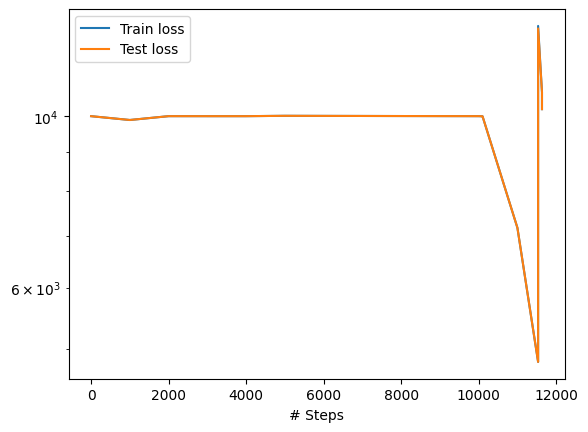

In [ ]:
dde.saveplot(losshistory, trainstate, issave=True, isplot=True)
plt.show()
plt.savefig("loss_history_plot_Heat2d")
plt.close()

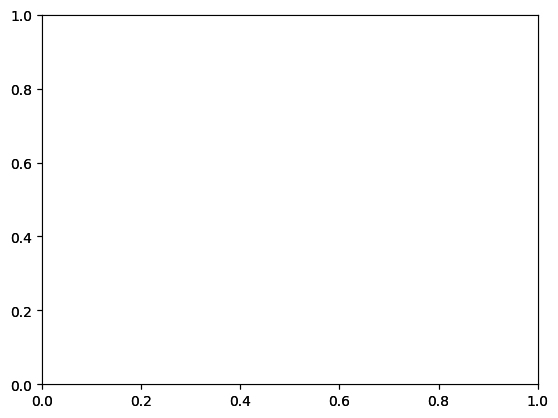

In [ ]:
# Predict the solution at different time points and create an animation
fig, ax = plt.subplots()
ax = fig.add_subplot(111)

# Set up the grid
nelx = 100  # Number of elements in x direction
nely = 100  # Number of elements in y direction
timesteps = 101  # Number of time steps
x = np.linspace(0, 1, nelx + 1)  # x coordinates
y = np.linspace(0, 1, nely + 1)  # y coordinates
t = np.linspace(0, 1, timesteps)  # Time points

# Prepare the data for the prediction
test_x, test_y, test_t = np.meshgrid(x, y, t)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_y), np.ravel(test_t))).T

In [ ]:
# Predict Solution and Residual
predicted_solution = model.predict(test_domain)
predicted_solution = predicted_solution.reshape(
    test_x.shape
)  # Scale and reshape solution
residual = model.predict(test_domain, operator=pde)
residual = residual.reshape(test_x.shape)  # Reshape residuals

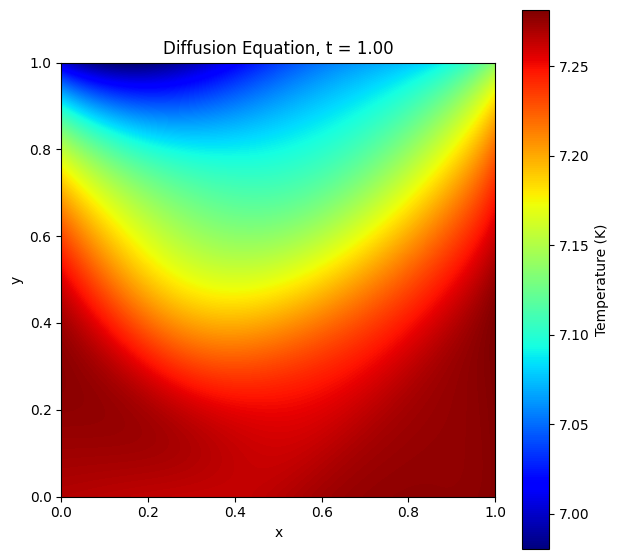

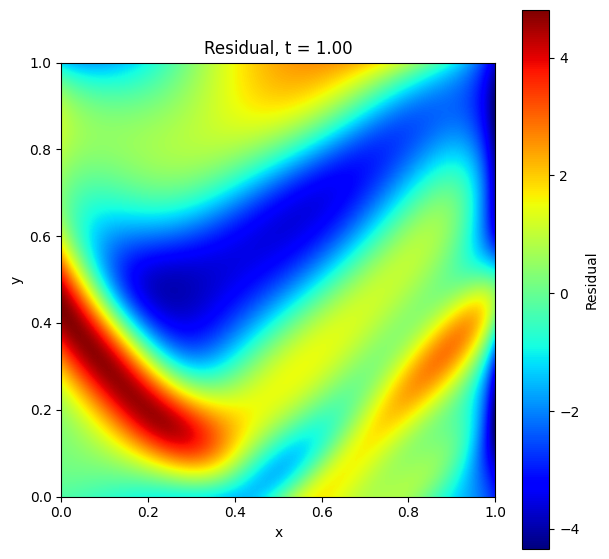

In [ ]:
# Animation function
def animate_solution(data, filename, title, label, t_data):
    fig, ax = plt.subplots(figsize=(7, 7))

    # Create initial image and colorbar
    im = ax.imshow(
        data[:, :, 0],
        origin="lower",
        cmap="jet",
        interpolation="bilinear",
        extent=[0, 1, 0, 1],
    )
    cb = plt.colorbar(im, ax=ax, label=label)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Update function for the frames
    def updatefig(k):
        # Update image data
        im.set_array(data[:, :, k])
        im.set_clim(
            vmin=data[:, :, k].min(), vmax=data[:, :, k].max()
        )  # Update the color limits

        # Update colorbar
        cb.update_normal(im)

        # Update title
        ax.set_title(f"{title}, t = {t_data[k]:.2f}")

        return [im]

    ani = animation.FuncAnimation(
        fig, updatefig, frames=range(data.shape[2]), interval=50, blit=True
    )
    ani.save(filename, writer="ffmpeg")


# Create and save the solution animation
animate_solution(
    predicted_solution,
    f"pinn_heat2d_solution_alpha_{str(ALPHA)}.mp4",
    "Diffusion Equation",
    "Temperature (K)",
    t,
)

# Create and save the residuals animation
animate_solution(
    residual,
    f"pinn_heat2d_residual_{str(ALPHA)}.mp4",
    "Residual",
    "Residual",
    t,
)

In [ ]:
def solver():
  u = np.empty((nelx, nely, timesteps)) #inicializando o grid u(i, j, k)
  u.fill(0)

  u[(nely-1):, :, :] = 1 #top
  u[:, :1, :] = 0 #left
  u[:1, 1:, :] = 0 #bottom
  u[:, (nelx-1):, :] = 0 #right

  delta_x = 1
  delta_t = (delta_x ** 2)/(4 * ALPHA)
  gamma = (ALPHA * delta_t) / (delta_x ** 2)

  for k in range(0, timesteps-1, 1):
    for i in range(1, nelx-1, delta_x):
      for j in range(1, nely-1, delta_x):
        u[i, j, k+1] = gamma * (u[i+1][j][k] + u[i-1][j][k] + u[i][j+1][k] + u[i][j-1][k] - 4*u[i][j][k]) + u[i][j][k]


  return u

In [ ]:
# Create and save the solution animation
u = solver()

animate_solution(
    u,
    f"SOLVER_pinn_heat2d_solution_alpha_{str(ALPHA)}.mp4",
    "Diffusion Equation",
    "Temperature (K)",
    t,
)